In [1]:
import get_encodings

3000
3000
<class 'tuple'>   10000   (array([[-0.431468  ],
       [ 0.529025  ],
       [-0.59223993],
       ...,
       [-0.04699569],
       [-0.95686334],
       [-0.0596275 ]]), 1)
<class 'tuple'>   10000   (array([[-0.47919601],
       [ 0.48843984],
       [-0.61794106],
       ...,
       [-0.19635084],
       [-0.69450551],
       [-0.07931382]]), 1)
<class 'tuple'>   10000   (array([[-0.79484182],
       [ 0.60530888],
       [-0.82525546],
       ...,
       [-0.20424215],
       [-1.08465727],
       [-0.15625726]]), 1)
<class 'tuple'>   10000   (array([[-0.61434766],
       [ 0.51588961],
       [-0.63647783],
       ...,
       [-0.11861566],
       [-0.82374401],
       [-0.18618892]]), 0)


In [4]:
len(get_encodings.far_OOD_encodings[2])

128

In [5]:
len(get_encodings.ID_encodings[9][0])

10000

In [6]:
get_encodings.near_ID_merge[0]

(array([[-0.45422179],
        [ 0.52194927],
        [-0.44254841],
        ...,
        [-0.20726757],
        [-0.87160892],
        [-0.12899512]]),
 1)

In [4]:
import numpy as np
import math
def OOD_detector(image_encoding, class_descriptors, theta_s):
    arccos_list = []
    for k, v in class_descriptors.items():
        if len(v) == 0:
            continue
        class_hv = v[0]
        dot_prod = np.dot(np.transpose(class_hv), image_encoding)
        arc_theta = dot_prod / (np.linalg.norm(class_hv)*np.linalg.norm(image_encoding))
        # print(arc_theta)
        arccos_list.append([k, arc_theta])
        arccos_list = sorted(arccos_list, key=lambda x:x[0])
    theta = list(map(lambda x: np.arccos(x[1])*(180/math.pi), arccos_list))
    closest_class = min(theta)
    result = 1 if closest_class > theta_s else 0
    closest_deg = round(closest_class[0][0])
    return result, closest_deg

In [5]:
x = OOD_detector(get_encodings.near_ID_merge[0][0], get_encodings.class_descriptors, 0)

In [6]:
x

(1, 17)

In [7]:
# results for far ood detection (MNIST)
def far_ood_results(theta_s):
    far_ood_res = []
    for e in get_encodings.far_ID_merge:
        image_encoding =  e[0]
        label = e[1]
        ood_pred, _ = OOD_detector(image_encoding, get_encodings.class_descriptors, theta_s)
        far_ood_res.append((ood_pred, label))
    return far_ood_res


In [8]:
far_ood_results(15)[0]

(1, 1)

In [9]:
# results for near ood detection (CIFAR100)
    
def near_ood_results(theta_s):
    near_ood_res = []
    for e in get_encodings.near_ID_merge:
        image_encoding =  e[0]
        label = e[1]
        ood_pred, _ = OOD_detector(image_encoding, get_encodings.class_descriptors, theta_s)
        near_ood_res.append((ood_pred, label))
    return near_ood_res

In [10]:
near_ood_results(15)[:1]

[(1, 1)]

In [11]:
def F1_score(results):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for e in results:
        pred = e[0]
        y = e[1]
        if pred == y:
            if pred == 1:
                TP += 1
            else:
                TN += 1
        else:
            if pred == 1:
                FP += 1
            else:
                FN += 1
    f1_score = TP/(TP + (0.5)*(FP + FN))
    
    return f1_score

In [58]:
#  F1 scores for theta_s between 10 and 50 degrees
from tqdm import tqdm
near_ood_f1 = []
far_ood_f1 = []
for theta_s in tqdm(range(10, 55, 1)):
    near_res_list = near_ood_results(theta_s)
    far_res_list = far_ood_results(theta_s)
    near_ood_f1.append(F1_score(near_res_list))
    far_ood_f1.append(F1_score(far_res_list))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:05<00:00,  2.78s/it]


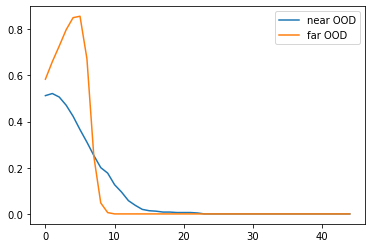

In [60]:
plt.plot(near_ood_f1, label='near OOD')
plt.plot(far_ood_f1, label='far OOD')
plt.legend()

In [16]:
# KDE plot
near_ood_degs = []
far_ood_degs = []
for e in get_encodings.near_list:
    image_encoding =  e[0]
    _, closest_deg = OOD_detector(image_encoding, get_encodings.class_descriptors, 0)
    near_ood_degs.append(closest_deg)
for e in get_encodings.far_list:
    image_encoding =  e[0]
    _, closest_deg = OOD_detector(image_encoding, get_encodings.class_descriptors, 0)
    far_ood_degs.append(closest_deg)

In [17]:
near_ood_degs[:10]

[17, 14, 14, 13, 18, 22, 18, 16, 12, 23]

In [18]:
far_ood_degs[:10]

[17, 15, 16, 15, 17, 16, 16, 15, 16, 16]

In [23]:
def bucket_sort_degs(degs_list):
    buckets = {}
    for d in degs_list:
        if d in buckets.keys():
            buckets[d] += 1
        else:
            buckets[d] = 1
    return buckets

In [45]:
near_ood_buckets = bucket_sort_degs(near_ood_degs)
far_ood_buckets = bucket_sort_degs(far_ood_degs)

In [47]:
# sorted(near_ood_buckets.keys())

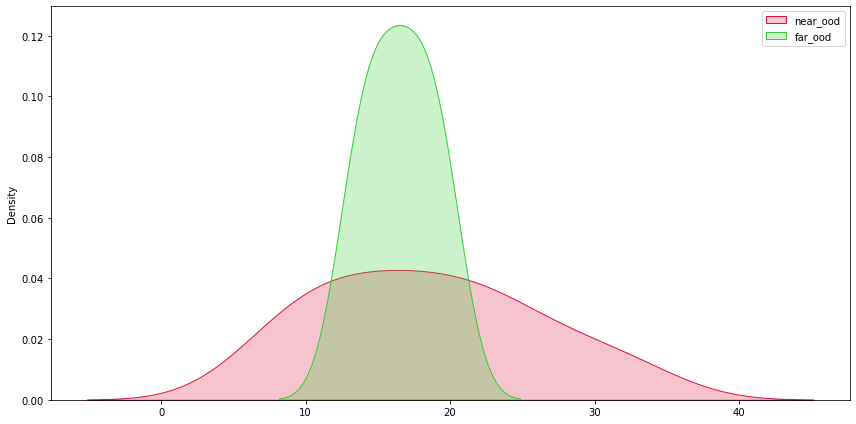

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

near_x = sorted(near_ood_buckets.keys())
near_y = sorted(near_ood_buckets.values())

far_x = sorted(far_ood_buckets.keys())
far_y = sorted(far_ood_buckets.values())

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=near_y, x=near_x,
            color='crimson', label='near_ood', fill=True, ax=ax)
sns.kdeplot(data=far_y, x=far_x,
            color='limegreen', label='far_ood', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

In [80]:
def FP_TP(results):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for e in results:
        pred = e[0]
        y = e[1]
        if pred == y:
            if pred == 1:
                TP += 1
            else:
                TN += 1
        else:
            if pred == 1:
                FP += 1
            else:
                FN += 1
    tpr = TP/(TP+FN)
    fpr = FP/(FP+TN)
    return fpr, tpr

In [95]:
# AUROC approximation
from tqdm import tqdm
near_TP_FP_list = []
far_TP_FP_list = []
for theta_s in tqdm(range(1, 90, 1)):
    near_res_list = near_ood_results(theta_s)
    far_res_list = far_ood_results(theta_s)
    near_TP_FP_list.append(FP_TP(near_res_list))
    far_TP_FP_list.append(FP_TP(far_res_list))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [04:29<00:00,  3.03s/it]


In [96]:
sum([i[0] for i in near_TP_FP_list])

11.274000000000004

In [97]:
def calc_auc_area(fpr_tpr_list):
    total_area = 0
    for i in range(len(fpr_tpr_list)-1):
        fpr_0 = fpr_tpr_list[i][0]
        tpr_0 = fpr_tpr_list[i][1]
        
        fpr_1 = fpr_tpr_list[i+1][0]
        tpr_1 = fpr_tpr_list[i+1][1]
        
        if fpr_0 == fpr_1:
            continue
        else:
            a = (fpr_0 - fpr_1)*(0.5)*(tpr_0 + tpr_1)
            total_area += a
    return total_area
        

In [98]:
calc_auc_area(near_TP_FP_list[5:33])

0.6435615000000001

In [106]:
calc_auc_area(far_TP_FP_list[5:31])

0.9192729999999999

In [101]:
# near_TP_FP_list